# Instance-level Uncertainty Analysis

This notebook shows the instance-level uncertainty estimation (UE) behavior of MIREL models. 

In this experiment, the input instances could be ID (in-distribution) and OOD (out-of-distribution) samples. These instances will be taken as the input of MIREL models for uncertainty analysis. 

Notes of the datasets used in the experiment:
- ID dataset is MNIST, and OOD dataset is FMNIST. 
- The digital `9` is selected as the class of interest (i.e., positive class).
- A bag is positive bag if and only if it contains at least one `9`. 

Two experiments are presented in this notebook:
- **ID instances**: we show the distribution of predictive confidence for the images (instances) per ID class (0-9 for MNIST dataset).
- **ID & OOD instance**: we show the distribution of predictive confidence for ID and OOD images (instances).

## 1. Set global variables and load configurations

In [1]:
import os

ROOT_DIR = "/home/liup/repo/MIREL"
os.chdir(ROOT_DIR)
os.getcwd()

'/home/liup/repo/MIREL'

In [2]:
DATA_ORIGIN = 'mnist' # mnist
OOD_DATA = 'fmnist' # fmnist, kmnist
NUM_ID_INSTANCE = 10000
RUN_SEED = 42

PATH_CFG = 'config/mnist-bags/cfg_abmil_mirel.yaml'

### loading the configuration (`YAML` file) of MIREL models.

In [3]:
import yaml
import os.path as osp

config_path = osp.join(ROOT_DIR, PATH_CFG)
with open(config_path, "r") as setting:
    cfg = yaml.load(setting, Loader=yaml.FullLoader)
print(cfg)

{'task': 'clf', 'cuda_id': 0, 'seed': [42, 17, 26, 50, 82], 'wandb_dir': '/home/user/repo/MIREL', 'wandb_prj': 'MIREL-Experiment', 'save_path': './result/mirel-experiment/mnist-ABMIL-MIREL', 'save_prediction': True, 'save_ins_prediction': True, 'ins_pred_from': 'eins', 'eins_frozen_feat': False, 'dataset_origin': 'mnist', 'mnist_dataset_size': '500-100-1000', 'mnist_target_number': 9, 'mnist_mean_bag_length': 10, 'mnist_var_bag_length': 2, 'mnist_mean_pos_ratio': 0.5, 'mnist_id_labels': '0-1-2-3-4-5-6-7-8-9', 'mnist_ood_ratio': 1.0, 'mnist_ood_origin': ['fmnist', 'kmnist'], 'net_dims': '800-256-2', 'drop_rate': 0.0, 'backbone': 'ABMIL', 'use_feat_proj': 'mnist', 'init_wt': True, 'abmil_pooling': 'attention', 'edl_pred_head': 'default', 'edl_evidence_func': 'exp', 'edl_evidence_sum': True, 'edl_evidence_sum_separate': 'II', 'edl_evidence_sum_aggregate': 'diweight', 'loss_bce': True, 'loss_smoothing': 0.0, 'loss_bce_target_thresh': None, 'loss_edl': True, 'loss_edl_type': 'mse', 'loss_re

### Model setup

get the path of trained model

In [4]:
cfg[DATA_ORIGIN+'_ood_origin'] = OOD_DATA
cfg['seed'] = RUN_SEED

dir_save = cfg['save_path'] + '-seed_{}'.format(cfg["seed"]) + '-' + DATA_ORIGIN + '_ood_origin_' + OOD_DATA
ckpt_path = osp.join(dir_save, 'train_model-best.pth')
if osp.exists(ckpt_path):
    print("Model will be loaded from", ckpt_path)
else:
    print("Model path is not found.")

Model will be loaded from ./result/mirel-experiment/mnist-ABMIL-MIREL-seed_42-mnist_ood_origin_fmnist/train_model-best.pth


load the MIREL model

In [5]:
import torch
from utils.func import seed_everything, parse_str_dims
from model.model_utils import load_model

torch.cuda.set_device(cfg['cuda_id'])
seed_everything(cfg['seed'])

dims = parse_str_dims(cfg['net_dims'])
model = load_model(
    cfg['task'], cfg['backbone'], dims, drop_rate=cfg['drop_rate'], use_feat_proj=cfg['use_feat_proj'], 
    edl_output=cfg['loss_edl'], edl_evidence_func=cfg['edl_evidence_func'], edl_pred_head=cfg['edl_pred_head'], 
    pooling=cfg['abmil_pooling'], ins_pred_from=cfg['ins_pred_from'], eins_frozen_feat=cfg['eins_frozen_feat'],
).cuda()

net_ckpt = torch.load(ckpt_path)
model.load_state_dict(net_ckpt['model'])
model.eval()

[setup] seed: 42
[info] Initialized an instance enhancement layer: frozen_feat = False.
[info] Initialized an ABMIL model with EDL_head, and the pooling is attention.


ABMIL(
  (feat_proj): MNIST_Feat_Projecter(
    (feature_extractor_part1): Sequential(
      (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
      (1): Dropout2d(p=0, inplace=False)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
      (5): Dropout2d(p=0, inplace=False)
      (6): ReLU()
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (projecter): Sequential(
      (0): Linear(in_features=800, out_features=800, bias=True)
      (1): ReLU()
    )
  )
  (ins_layer): Scoring_Net(
    (attention): Sequential(
      (0): Linear(in_features=800, out_features=256, bias=True)
      (1): Tanh()
      (2): Linear(in_features=256, out_features=1, bias=True)
    )
  )
  (pred_head): Linear(in_features=800, out_features=2, bias=True)
  (ins_enhance_layer): Sequential(
    (0): Linear(in_features=800, out_features=256, bias=True)
 

### Instance-level dataset setup

In [6]:
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader

from dataset.VisionData import DTD


def get_ID_test_loader():
    if DATA_ORIGIN == 'mnist':
        data = datasets.MNIST('./datasets', train=False, download=True,
            transform=transforms.Compose([transforms.ToTensor()]))
    elif DATA_ORIGIN == 'cifar10':
        data = datasets.CIFAR10('./datasets', train=False, download=True,
            transform=transforms.Compose([transforms.ToTensor()]))
    else:
        data = None
    
    assert len(data) == NUM_ID_INSTANCE
    
    loader = DataLoader(data, batch_size=256, num_workers=4, shuffle=False)
    return data, loader
    
def to_ood_label(x):
    return -1 * (x + 1)
    
def get_OOD_test_loader(data_size):
    if OOD_DATA == 'fmnist':
        data = datasets.FashionMNIST('./datasets', train=True, download=True,
            transform=transforms.Compose([transforms.ToTensor()]),
            target_transform=to_ood_label)
    elif OOD_DATA == 'kmnist':
        data = datasets.KMNIST('./datasets', train=True, download=True,
            transform=transforms.Compose([transforms.ToTensor()]),
            target_transform=to_ood_label)
    elif OOD_DATA == 'dtd':
        data = DTD('./datasets', split="test", download=True,
            transform=transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()]),
            target_transform=to_ood_label
        )
    elif OOD_DATA == 'svhn':
        data = datasets.SVHN('./datasets', split='test', download=True,
            transform=transforms.Compose([transforms.ToTensor()]),
            target_transform=to_ood_label)
    else:
        data = None
    
    data_size = min(len(data), data_size)
    print("[info] load {} instances from {}".format(data_size, OOD_DATA))
    # randomly select `data_size` samples
    sel_idxs = np.random.permutation(len(data))[:data_size].tolist()
    data = Subset(data, sel_idxs)
    
    loader = DataLoader(data, batch_size=256, num_workers=4, shuffle=False)
    return data, loader

### Model inference

In [7]:
from utils.func import has_no_ood_instance

def test_model(model, instance_loader):
    """
    we only use the instance-level predictions.
    """
    model.eval()
    
    all_pred_ins, all_gt_ins = [], []
    cnt_samples = 0
    for data_x, data_y in instance_loader:
        # data_x = [B, C, W, H] | data_y = [B, ]
        X = data_x.unsqueeze(0).cuda() # [1, B, C, W, H] like a mini-batch bag  
        ins_label = data_y.unsqueeze(0)
        cnt_samples += X.shape[1]

        with torch.no_grad():
            logit_bag, ins_pred = model(X, ret_ins_res=True)
            if isinstance(ins_pred, tuple):
                ins_pred = ins_pred[1] # fetch the last one, i.e., enhanced instace predictions
        
        all_gt_ins.append(ins_label.squeeze(0).tolist())
        all_pred_ins.append(ins_pred.squeeze(0).tolist())
        assert len(all_gt_ins[-1]) == len(all_pred_ins[-1]), "Please check the instance-level dimension."
    
    # the first two elements are in python list style
    cltor = {'y': all_gt_ins, 'y_hat': all_pred_ins}
    print("[info] finished testing {} instances".format(cnt_samples))
    
    return cltor

## 2. Put all together and run it

In [8]:
from utils.func import convert_instance_output

print(">>>>>>>>>> Start testing ID instances from {}.".format(DATA_ORIGIN))
ID_dataset, ID_test_loader = get_ID_test_loader()
ID_res = test_model(model, ID_test_loader)
ID_labels = []
for item in ID_res['y']:
    ID_labels += item 
ID_labels = torch.LongTensor(ID_labels)
ID_res = convert_instance_output(ID_res, cfg) 
print("<<<<<<<<<< End of testing\n")

print(">>>>>>>>>> Start testing OOD instances from {}.".format(OOD_DATA))
OOD_dataset, OOD_test_loader = get_OOD_test_loader(NUM_ID_INSTANCE)
OOD_res = test_model(model, OOD_test_loader)
OOD_labels = []
for item in OOD_res['y']:
    OOD_labels += item 
OOD_labels = torch.LongTensor(OOD_labels)
OOD_res = convert_instance_output(OOD_res, cfg)
print("<<<<<<<<<< End of testing\n")

>>>>>>>>>> Start testing ID instances from mnist.


/usr/local/lib64/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib64/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_

[info] finished testing 10000 instances
<<<<<<<<<< End of testing

>>>>>>>>>> Start testing OOD instances from fmnist.
[info] load 10000 instances from fmnist
[info] finished testing 10000 instances
<<<<<<<<<< End of testing



## 3. Calculate instance-level confidence scores

In [9]:
import torch
import torch.nn.functional as F

from eval.edl_metrics import compute_confidence_score
from eval.edl_metrics import compute_confidence_score_categorical

# Use `expected_entropy` for example
UNCERTAINTY_TYPES = ['expected_entropy']
# UNCERTAINTY_TYPES = ['expected_entropy', 'alpha0', 'differential_entropy', 'mutual_information'] 

def convert_to_tensor(data):
    new_data = dict()
    for k in data.keys():
        k_data = data[k]
        if type(k_data) == torch.Tensor:
            k_data = k_data.squeeze().cpu() # [N, ]
        elif type(k_data) == np.ndarray:
            k_data = torch.from_numpy(np.squeeze(k_data)) # [N, ]
        new_data[k] = k_data
    return new_data

def instance_uncertainty_estimation(data, verbose=False):
    edl_output = (cfg['ins_pred_from'] == 'ins' and cfg['abmil_pooling'] == 'edl') \
                    or (cfg['ins_pred_from'] in ['bag', 'eins'] and cfg['loss_edl'])
    
    Y, Y_soft, Y_hat = data['y'], data['y_soft'], data['y_hat']
    
    if verbose:
        print("Instance labels:\n", Y[:10])
        print("Instance-level labels (Neg. = OOD instances):\n", Y_soft[:10])
    
    conf_scores = dict()
    for ut in UNCERTAINTY_TYPES:
        if edl_output:
            scores = compute_confidence_score(Y_hat, ut)
        else:
            # print(Y_hat.shape)
            assert len(Y_hat.shape) == 1
            new_Y_hat = torch.cat([(1 - Y_hat).unsqueeze(-1), Y_hat.unsqueeze(-1)], dim=1)
            scores = compute_confidence_score_categorical(new_Y_hat, ut)
        conf_scores[ut] = scores
    return conf_scores

In [10]:
print(">>>>>>>>>> Start measuring uncertainty for the ID instances of {}.".format(DATA_ORIGIN))
ID_res = convert_to_tensor(ID_res)
ID_scores = instance_uncertainty_estimation(ID_res, verbose=True)

print(">>>>>>>>>> Start measuring uncertainty for the OOD instances of {}.".format(OOD_DATA))
OOD_res = convert_to_tensor(OOD_res)
OOD_scores = instance_uncertainty_estimation(OOD_res, verbose=True)

>>>>>>>>>> Start measuring uncertainty for the ID instances of mnist.
Instance labels:
 tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 1])
Instance-level labels (Neg. = OOD instances):
 tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 1])
>>>>>>>>>> Start measuring uncertainty for the OOD instances of fmnist.
Instance labels:
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Instance-level labels (Neg. = OOD instances):
 tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1])


## 4. Visualization of instance-level confidence score distribution

In [11]:
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
mpl.rc('pdf', fonttype=42)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

In [12]:
def visualize_conf_scores(xs, all_scores, title, colors=None, cumulative=False, norm=False, bw_adjust=1, save_path=None):
    sns.set_theme(style="whitegrid", palette='deep') # white/dark/whitegrid/darkgrid/ticks
    figure, axes = plt.subplots(figsize=(4.5,4))
    if norm:
        score_min = min([s.min() for s in all_scores])
        score_max = max([s.max() for s in all_scores])
        norm_scores = []
        for i in range(len(all_scores)):
            nyi = (all_scores[i] - score_min) / (score_max - score_min)
            norm_scores.append(nyi)
        all_scores = norm_scores
    
    logscale = True if title == 'alpha0' and not norm else False
    for i in range(len(all_scores)):
        if colors is not None:
            sns.kdeplot(all_scores[i], ax=axes, cumulative=cumulative, legend=True, label=xs[i], log_scale=logscale, color=colors[i],
                       linewidth=2.1)
        else:
            sns.kdeplot(all_scores[i], ax=axes, cumulative=cumulative, legend=True, label=xs[i], log_scale=logscale,
                       linewidth=2.1)
    
    axes.set_xlabel(f"Instance-level predictive confidence")
    axes.set_ylabel("Cumulative density")
    if norm:
        axes.set_xlim([0, 1])
    if cumulative:
        axes.set_ylim([0, 1])
    plt.legend()
    axes.spines['bottom'].set_linewidth(0.8)
    axes.spines['left'].set_linewidth(0.8)
    axes.spines['right'].set_linewidth(0.8)
    axes.spines['top'].set_linewidth(0.8)
    axes.spines['bottom'].set_color('black')
    axes.spines['left'].set_color('black')
    axes.spines['right'].set_color('black')
    axes.spines['top'].set_color('black')
    plt.tick_params(reset=True, direction='out', length=3, width=1, colors='black', top=False,right=False)
    if save_path is not None:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    plt.show()
    
def visualize_bag_sample(bag_sample, label=None):
    n_ins = bag_sample.shape[0]
    new_bag_sample = np.ones((28, 28*n_ins))
    for i in range(n_ins):
        new_bag_sample[:, (i*28):(i*28+28)] = bag_sample[i].numpy()
    
    sns.set_theme(style="white")
    figure, axes = plt.subplots(figsize=(n_ins * 0.8, 6))
    axes.set_title(label)
    axes.imshow(new_bag_sample, cmap='gray')

### Visualization 1: the distribution of predictive confidence for the instanches per ID class

Instance samples per class are shown below. We can observe that
- The hand-written digital `4` (negative class) could be confused and recognized as `9` (positive class).
- Moreover, the hand-written digital `7` (negative class) could be confused and recognized as `9` (positive class).

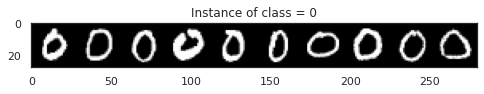

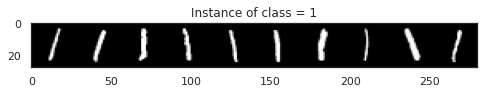

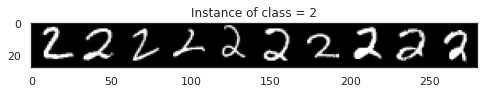

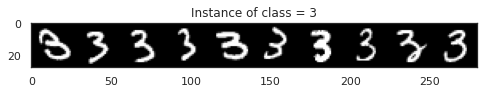

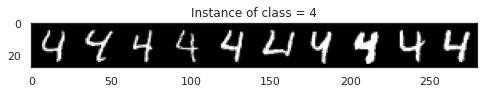

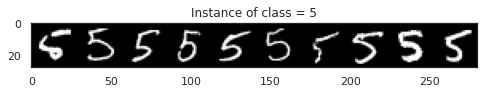

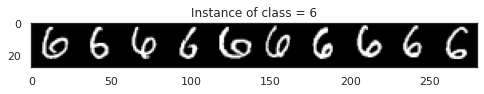

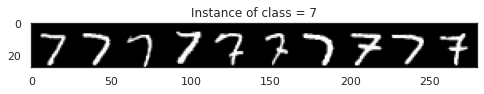

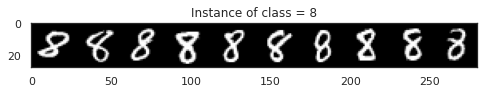

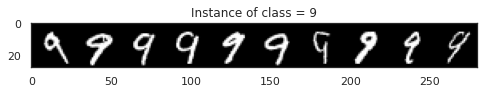

In [13]:
for digital in range(10):
    idxs_per_class = torch.nonzero(ID_labels == digital)[:10, 0]
    samples_per_class = torch.cat([ID_dataset[i][0] for i in idxs_per_class], dim=0)
    visualize_bag_sample(samples_per_class, label=f"Instance of class = {digital}")

---

The distribution of predictive confidence of the instance per class is shown below. We could find that
- The digital `9` (positive class) often exhibits high predictive confidence in the MIREL model. 
- The MIREL model often predicts lower confidence for the images with `4` or `7`. These images could be easily confused with the target digital `9`.
- The MIREL model could capture the uncertainty in those easily-confused images.

Predictive confidence measured by expected_entropy


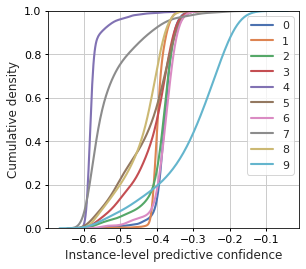

In [14]:
for i, unc in enumerate(UNCERTAINTY_TYPES):
    if ID_scores[unc] is None:
        print(f"No scores, so skipping the {unc}")
        continue
    xs = []
    all_scores = []
    
    print("Predictive confidence measured by", unc)
    assert len(ID_labels) == len(ID_scores[unc])
    for digital in range(10):
        sel_idx = ID_labels == digital
        xs.append(digital)
        all_scores.append(ID_scores[unc][sel_idx])
    visualize_conf_scores(xs, all_scores, unc, cumulative=True, norm=False, bw_adjust=1)

### Visualization 2: the distribution of predictive confidence for ID and OOD instances

ID and OOD instance samples are shown below:

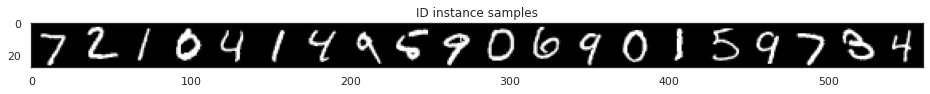

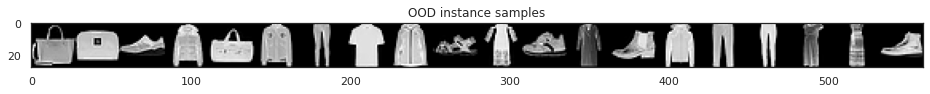

In [15]:
ID_samples = torch.cat([ID_dataset[i][0] for i in range(20)], dim=0)
visualize_bag_sample(ID_samples, label=f"ID instance samples")
OOD_samples = torch.cat([OOD_dataset[i][0] for i in range(20)], dim=0)
visualize_bag_sample(OOD_samples, label=f"OOD instance samples")

---

The distribution of predictive confidence of ID and OOD instances are shown below. 

We could see that the MIREL model could often produce higher confidence for ID instances and lower confidence for OOD ones.

Predictive confidence measured by expected_entropy


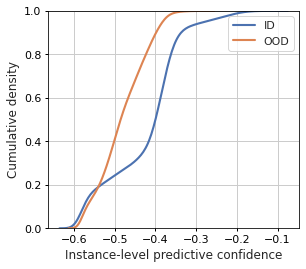

In [16]:
for i, unc in enumerate(UNCERTAINTY_TYPES):
    xs = ["ID", "OOD"]
    if ID_scores[unc] is None:
        print(f"No scores, so skipping the {unc}")
        continue
    all_scores = [ID_scores[unc], OOD_scores[unc]]
    
    print("Predictive confidence measured by", unc)
    visualize_conf_scores(xs, all_scores, unc, cumulative=True, norm=False, bw_adjust=1)